# **Ejercicio 1**
# Descripción de los modelos GP

# GPR 

# GPC

# VGP

# SGPR

# SVGP

# **Ejercicio 2**
# Descripción de la optimización por tensorflow y scipy

# **Ejercicio 3**
# Clasificador multiclase con SVGP

**Instalamos la libreria de GPFlow**

In [2]:
!pip install gpflow --upgrade #tensorflow~=2.12.0 tensorflow-probability~=0.20.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.9/392.9 kB 8.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 8.4 MB/s eta 0:00:00


**Importamos paquetes, definimos funciones y llamamos los datos de FashionMNIST**

In [3]:
import gpflow
from gpflow.ci_utils import reduce_in_tests
from gpflow.utilities import print_summary, set_trainable
import tensorflow as tf
import numpy as np
import pandas as pd

# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas importamos matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
print(tf.__version__)
print(gpflow.__version__)

2.16.1
2.9.2


**Debido a las limitaciones de los GPs con conjuntos de datos grandes, tomamos solo los primeros 10000 datos del conjunto de entrenamiento de FashionMNIST**

In [17]:
x_train=X_train[:10000]
y_train=y_train[:10000]
print(x_train.shape)
print(y_train.shape)

(10000, 28, 28)
(10000,)


**Para poder entrenar el modelo, es necesario aplanar las imagenes de 28x28 a una sola dimension de 784, y para evitar errores de tipo pasamos todos los datos a float64**

In [18]:
x_train_f = x_train.reshape(-1,28*28)
print(x_train_f.shape)
y_train_f=y_train.reshape(-1,1)
print(y_train_f.shape)
x_train_64 = x_train_f.astype(np.float64)
y_train_64 = y_train_f.astype(np.float64)
data_train=(x_train_64,y_train_64)

(10000, 784)
(10000, 1)


**De forma similar, vamos a verificar las predicciones solo con 1000 datos del conjunto de prueba de FashionMNIST**

In [19]:
x_test = X_test[:1000]
y_test=y_test[:1000]
print(x_test.shape)
print(y_test.shape)

(1000, 28, 28)
(1000,)


**Y aplanamos estas imagenes también, asi como las convertimos a float64**

In [20]:
x_test_f = x_test.reshape(-1,28*28)
print(x_test_f.shape)
y_test_f=y_test.reshape(-1,1)
print(y_test_f.shape)
x_test_64 = x_test_f.astype(np.float64)
y_test_64 = y_test_f.astype(np.float64)

(1000, 784)
(1000, 1)


**Definimos el modelo usando los kernels, el liklihood multiclase y el modelo sparse variational de gpflow**

In [21]:
#Definmos los kernels a usar, el kernel Matern32 es estandar para la aplicacion de clasificacion, y el white añade ruido gausiano fijo
kernel = gpflow.kernels.Matern32() + gpflow.kernels.White(variance=0.01) 

#Definimos el numero de clases para clasificar, FashionMNIST tiene 10
C = 10

# Definimos el liklihood y la funcion para mapear las salidas latentes del GP a las probabilidades de clase (invlink)
# Robustmax se usa para asegurar que las probabilidades nunca sean 1 o 0, evitando problemas de confianza exagerada o asturación. 
# Tambien ayuda a modelar mejor la incertidumbre o varianza
invlink = gpflow.likelihoods.RobustMax(C)  
likelihood = gpflow.likelihoods.MultiClass(#El liklihood Multiclass es el estandar de GPFlow para clasificacon multiclase
    C, invlink=invlink
) 
Z = x_train_64[::5].copy()  # Se definen los puntos inducidos para manejar el problema del costo computacional
#Z trata de representar el conjunto total de datos con menos información para que sea más facil resolver el GP al invertir las matrices

#Llamamos todo lo definido anteriormente para definir el modelo m
m = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=C,#tenemos igual numero de latentes como clases para clasificar
    whiten=True,#Mejora la estabilidad eliminando la covarianza entre las variables inducidas Z
    q_diag=True,#Asume covarianza diagonal para mejorar el rendimiento
)

# Evitamos que se entrene la vanrianza del ruido
set_trainable(m.kernel.kernels[1].variance, False)
# Evitamos que se modifiquen los puntos Z inducidos
set_trainable(m.inducing_variable, False)
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(2000, 784)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(2000, 10)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,,True,"(2000, 10)",float64,"[[1., 1., 1...."


In [22]:
opt = gpflow.optimizers.Scipy() #Llamamos Scipy para la optimizacion

#Entrenamos
opt_logs = opt.minimize(
    m.training_loss_closure(data_train),#Minimizando el loss
    m.trainable_variables,
    options=dict(maxiter=reduce_in_tests(1000)),#definimos un maximo de 1000 iteraciones para evitar sobrecarga computacional
)
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,57.20021
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,52.42083
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(2000, 784)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(2000, 10)",float64,"[[-0.85056459, -0.78498826, -0.30280321..."
SVGP.q_sqrt,Parameter,Softplus,,True,"(2000, 10)",float64,"[[0.00358828, 0.00782771, 0.00312437..."


**Prediccion usando los datos de prueba**

In [23]:
prediction  = m.predict_y(x_test_64)

In [26]:
print(prediction[0].shape)

(1000, 10)


**Verificamos el accuracy de las predicciones**

In [27]:
from sklearn.metrics import accuracy_score

# Predicciones (one-hot encoded) y etiquetas reales
predicciones_one_hot = prediction[0]  #Prediccones en formato one-hot encoding que salen directamente del modelo
etiquetas_reales = y_test_64  # Etiquetas reales

# Convertir one-hot encoded a etiquetas discretas (índices de clases)
predicciones_labels = np.argmax(predicciones_one_hot, axis=1)

# Calcular precisión
precision = accuracy_score(etiquetas_reales, predicciones_labels)
print(f'Precisión: {precision * 100:.2f}%')

Precisión: 86.60%


**Graficamos una matriz de confusion**

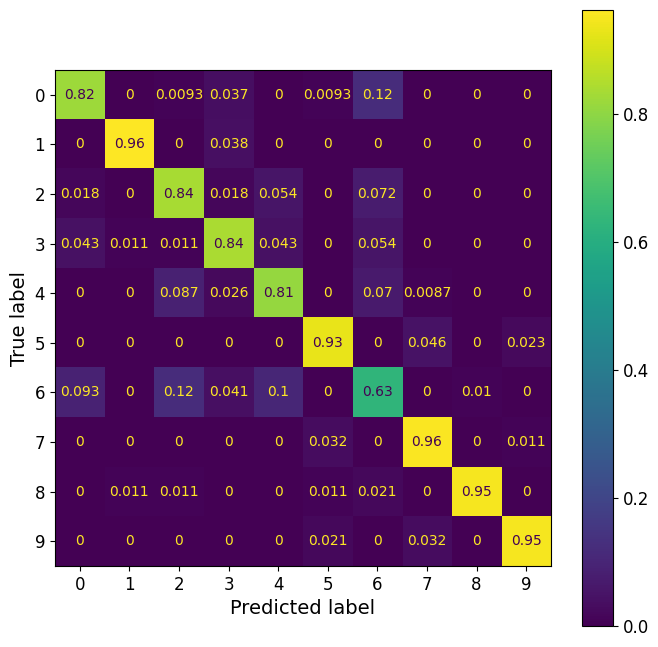

In [35]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


# Generar matriz de confusión normalizada
cm = confusion_matrix(etiquetas_reales, predicciones_labels,normalize="true")

# Visualizamos la matriz de confusion
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)

# **Discusion de las ventajas y desventajas comparado con un autoencoder variacional**

## Ejercicio

- Describa el modelo y la optimización de los GPR, GPC, VGP, SGPR, y SVGP.

- Discuta los métodos de optimización que utiliza GPFlow con scipy y TensorFlow.

- Implemente un clasificador multiclase, para la base de datos fashionMnist, utilizando un Sparse GP implementado con GPflow y optimizador de TensorFlow. (ver [https://gpflow.github.io/GPflow/develop/getting_started.html](https://gpflow.github.io/GPflow/develop/getting_started.html))

- Discuta las ventajas y desventajas de un clasificador tipo autoencoder variacional vs un modelo basado en GP y GPflow.